In [1]:
import warnings
warnings.simplefilter(action='ignore')

In [2]:
import scanpy as sc
import torch
import scarches as sca
import matplotlib.pyplot as plt
import numpy as np

In [3]:
sc.set_figure_params(dpi=200, figsize=(4, 4), frameon=False)
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

In [4]:
%load_ext autoreload
%autoreload 2

### Download Dataset and split into reference dataset and query dataset

In [5]:
adata = sc.read('./pbmc_vars_sb.h5ad')

In [6]:
adata = adata[adata.obs['study']!='Villani'].copy()

In [7]:
adata.X = adata.layers["counts"].copy()

In [9]:
sca.add_annotations(adata, '../metadata/c2.cp.reactome.v4.0.symbols.gmt', min_genes=12)

In [10]:
adata._inplace_subset_var(adata.varm['I'].sum(1)>0)

In [11]:
sc.pp.normalize_total(adata)

In [12]:
sc.pp.log1p(adata)

In [13]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    batch_key="batch",
    subset=True)

In [14]:
select_terms = adata.varm['I'].sum(0)>12

In [15]:
adata.uns['terms'] = np.array(adata.uns['terms'])[select_terms].tolist()

In [16]:
adata.varm['I'] = adata.varm['I'][:, select_terms]

In [17]:
adata._inplace_subset_var(adata.varm['I'].sum(1)>0)

In [18]:
adata.X = adata.layers["counts"].copy()

### Create TRVAE model and train it on reference dataset

In [84]:
intr_cvae = sca.models.TRVAE(
    adata=adata,
    condition_key='study',
    hidden_layer_sizes=[256, 256, 256],
    use_mmd=False,
    recon_loss='nb',
    mask=adata.varm['I'].T,
    use_decoder_relu=False,
    mmd_instead_kl=False,
    use_l_encoder=True,)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1972 256 4
	Hidden Layer 1 in/out: 256 256
	Hidden Layer 2 in/out: 256 256
	Mean/Var Layer in/out: 256 282
Encoder Architecture:
	Input Layer in, out and cond: 1972 128 4
	Mean/Var Layer in/out: 128 1
Decoder Architecture:
	Masked linear layer in, out and cond:  282 1972 4


In [85]:
ALPHA = 0.7

In [86]:
EPOCHS = 400

In [87]:
early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss", # val_unweighted_loss
    "threshold": 0,
    "patience": 50,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}

In [88]:

intr_cvae.train(
    n_epochs=EPOCHS, 
    alpha_epoch_anneal=100, 
    alpha=ALPHA, 
    omega=None,
    alpha_kl=0.5,
    weight_decay=0., 
    early_stopping_kwargs=early_stopping_kwargs,
    use_early_stopping=True,
    seed=2020)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


 |██████--------------| 31.0%  - epoch_loss:  879.67 - epoch_recon_loss:  855.57 - epoch_kl_loss:   48.19 - val_loss:  945.52 - val_recon_loss:  920.36 - val_kl_loss:   50.33
ADJUSTED LR
 |███████-------------| 35.0%  - epoch_loss:  878.65 - epoch_recon_loss:  854.55 - epoch_kl_loss:   48.20 - val_loss:  943.89 - val_recon_loss:  919.03 - val_kl_loss:   49.73
ADJUSTED LR
 |███████-------------| 38.2%  - epoch_loss:  879.99 - epoch_recon_loss:  855.85 - epoch_kl_loss:   48.26 - val_loss:  945.47 - val_recon_loss:  920.65 - val_kl_loss:   49.64
ADJUSTED LR
 |████████------------| 41.5%  - epoch_loss:  881.10 - epoch_recon_loss:  856.93 - epoch_kl_loss:   48.34 - val_loss:  943.30 - val_recon_loss:  918.48 - val_kl_loss:   49.63
ADJUSTED LR
 |█████████-----------| 47.5%  - epoch_loss:  882.08 - epoch_recon_loss:  857.95 - epoch_kl_loss:   48.26 - val_loss:  946.15 - val_recon_loss:  921.31 - val_kl_loss:   49.68
ADJUSTED LR
 |██████████----------| 50.7%  - epoch_loss:  879.51 - epoch_reco

In [89]:
inactive_idx = ~(intr_cvae.model.decoder.L0.expr_L.weight.data.norm(p=2, dim=0)>0).cpu().numpy()

In [90]:
print('Inactive terms:')
[term for i, term in enumerate(adata.uns['terms']) if inactive_idx[i]]

Inactive terms:


['GROWTH_HORMONE_RECEPTOR_SIGNAL',
 'O_LINKED_GLYCOSYLATION_OF_MUCI',
 'SPHINGOLIPID_DE_NOVO_BIOSYNTHE',
 'PRE_NOTCH_TRANSCRIPTION_AND_TR',
 'RORA_ACTIVATES_CIRCADIAN_EXPRE',
 'YAP1_AND_WWTR1_TAZ_STIMULATED_',
 'CIRCADIAN_REPRESSION_OF_EXPRES',
 'SMAD2_SMAD3_SMAD4_HETEROTRIMER',
 'DOWNREGULATION_OF_SMAD2_3_SMAD',
 'LATENT_INFECTION_OF_HOMO_SAPIE',
 'SIGNALING_BY_FGFR_MUTANTS',
 'BASIGIN_INTERACTIONS',
 'PHASE1_FUNCTIONALIZATION_OF_CO',
 'P53_DEPENDENT_G1_DNA_DAMAGE_RE',
 'RNA_POL_II_TRANSCRIPTION_PRE_I',
 'SEMA4D_INDUCED_CELL_MIGRATION_',
 'G_BETA_GAMMA_SIGNALLING_THROUG',
 'SMOOTH_MUSCLE_CONTRACTION',
 'EFFECTS_OF_PIP2_HYDROLYSIS',
 'REGULATION_OF_WATER_BALANCE_BY',
 'TRAF6_MEDIATED_IRF7_ACTIVATION',
 'ION_TRANSPORT_BY_P_TYPE_ATPASE',
 'ION_CHANNEL_TRANSPORT',
 'PKB_MEDIATED_EVENTS',
 'LIPID_DIGESTION_MOBILIZATION_A',
 'INFLAMMASOMES',
 'PACKAGING_OF_TELOMERE_ENDS',
 'CHOLESTEROL_BIOSYNTHESIS']

In [91]:
MEAN = False

In [92]:
adata.obsm['X_cvae'] = intr_cvae.get_latent(mean=MEAN)[:, ~inactive_idx]

In [93]:
sc.pp.neighbors(adata, use_rep='X_cvae')

In [94]:
sc.tl.umap(adata)

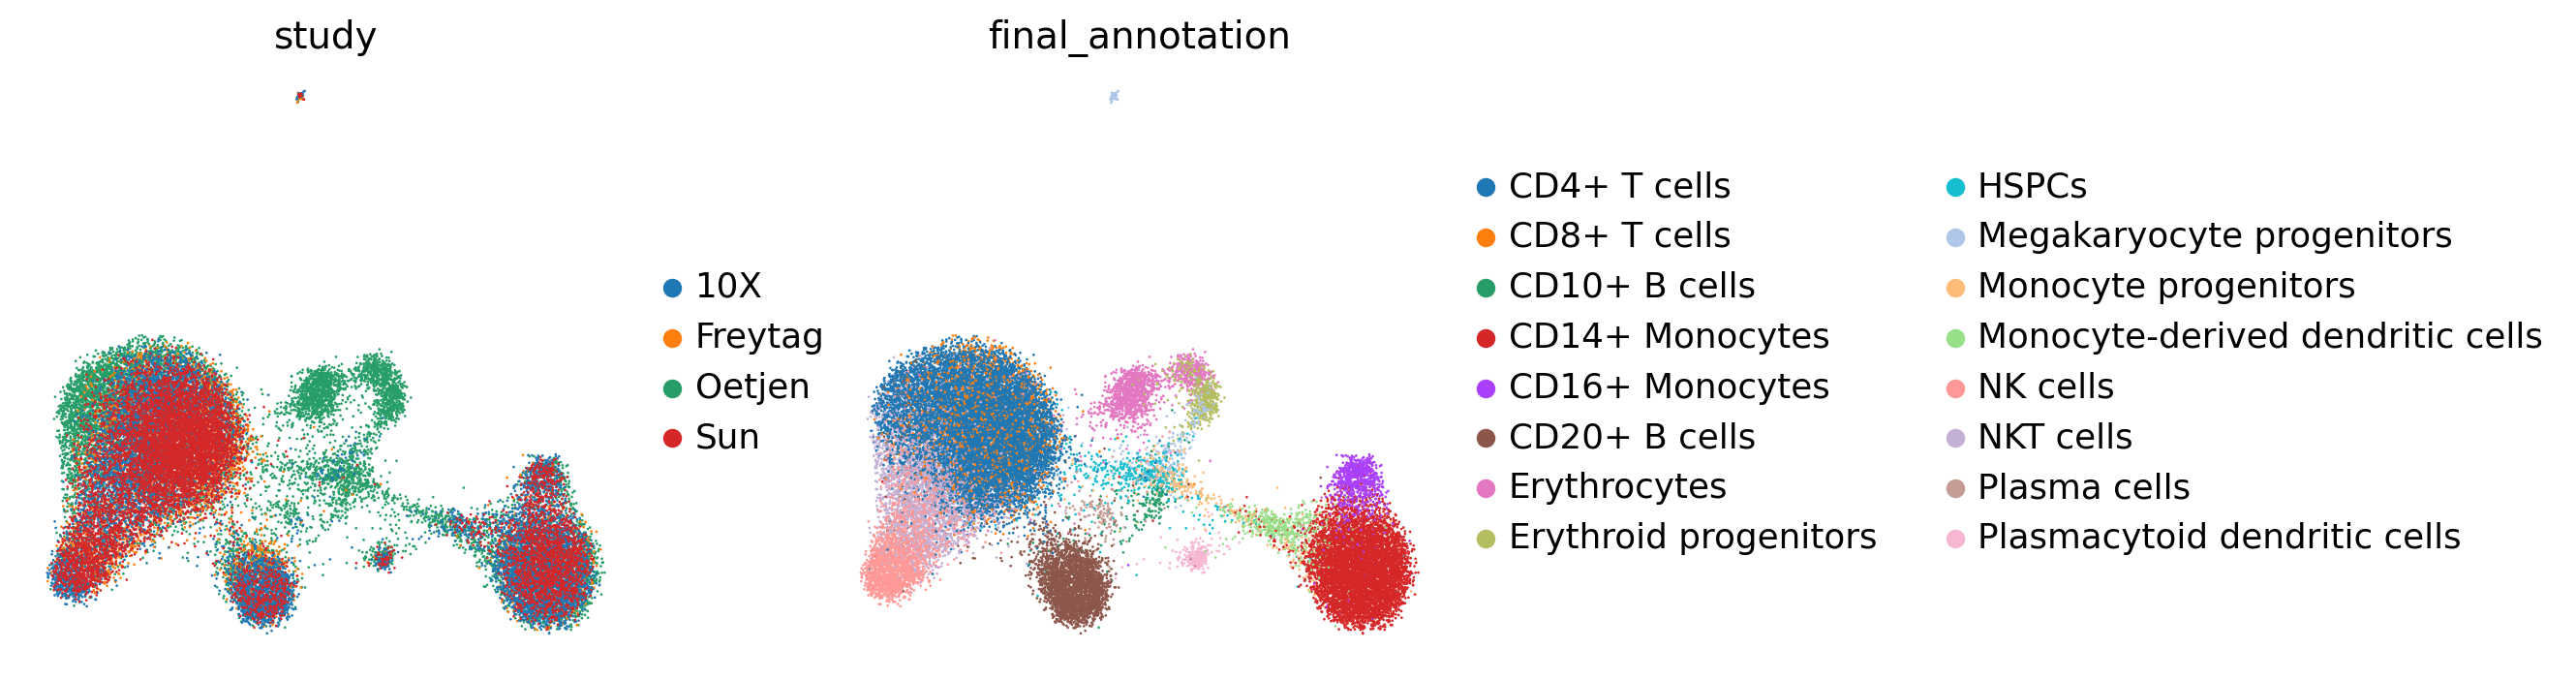

In [95]:
sc.pl.umap(adata, color=['study', 'final_annotation'], frameon=False)

In [97]:
intr_cvae.save('reference_l_encoder_softmax')

In [123]:
name = "reference_l_encoder_softmax"

In [98]:
kang = sc.read('./kang_count.h5ad')[:, adata.var_names].copy()

In [99]:
kang.obs['study'] = 'Kang'

In [100]:
#q_intr_cvae = sca.models.TRVAE.load('q_intr_cvae_nb_alpha_kl_0_001_sd_2021', kang)

In [182]:
q_intr_cvae = sca.models.TRVAE.load_query_data(kang, name)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1972 256 5
	Hidden Layer 1 in/out: 256 256
	Hidden Layer 2 in/out: 256 256
	Mean/Var Layer in/out: 256 282
Encoder Architecture:
	Input Layer in, out and cond: 1972 128 5
	Mean/Var Layer in/out: 128 1
Decoder Architecture:
	Masked linear layer in, out and cond:  282 1972 5


In [183]:
# q_intr_cvae.train(n_epochs=200, alpha_epoch_anneal=30, weight_decay=0.0, alpha_kl=0.05, seed=2020, use_early_stopping=True)
# q_intr_cvae.train(n_epochs=200, alpha_epoch_anneal=30, weight_decay=0.0, alpha_kl=0.01, seed=2020, use_early_stopping=True)
q_intr_cvae.train(n_epochs=200, alpha_epoch_anneal=30, weight_decay=0.0, alpha_kl=0.001, seed=2020, use_early_stopping=True)


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


 |███████████---------| 57.5%  - epoch_loss:  519.45 - epoch_recon_loss:  519.37 - epoch_kl_loss:   79.95 - val_loss:  521.62 - val_recon_loss:  521.54 - val_kl_loss:   79.86
ADJUSTED LR
 |████████████--------| 64.5%  - epoch_loss:  519.69 - epoch_recon_loss:  519.61 - epoch_kl_loss:   80.25 - val_loss:  522.03 - val_recon_loss:  521.95 - val_kl_loss:   79.89
ADJUSTED LR
 |█████████████-------| 68.0%  - epoch_loss:  517.32 - epoch_recon_loss:  517.24 - epoch_kl_loss:   79.76 - val_loss:  522.14 - val_recon_loss:  522.06 - val_kl_loss:   79.94
ADJUSTED LR
 |██████████████------| 71.0%  - epoch_loss:  518.41 - epoch_recon_loss:  518.33 - epoch_kl_loss:   79.91 - val_loss:  523.64 - val_recon_loss:  523.56 - val_kl_loss:   79.87
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 120


In [126]:
#q_intr_cvae.save('q_intr_cvae_nb_alpha_kl_0_001_sd_2021')

In [184]:
kang.obsm['X_cvae'] = q_intr_cvae.get_latent(mean=MEAN)[:, ~inactive_idx]

In [185]:
sc.pp.neighbors(kang, use_rep='X_cvae')

In [186]:
sc.tl.umap(kang)

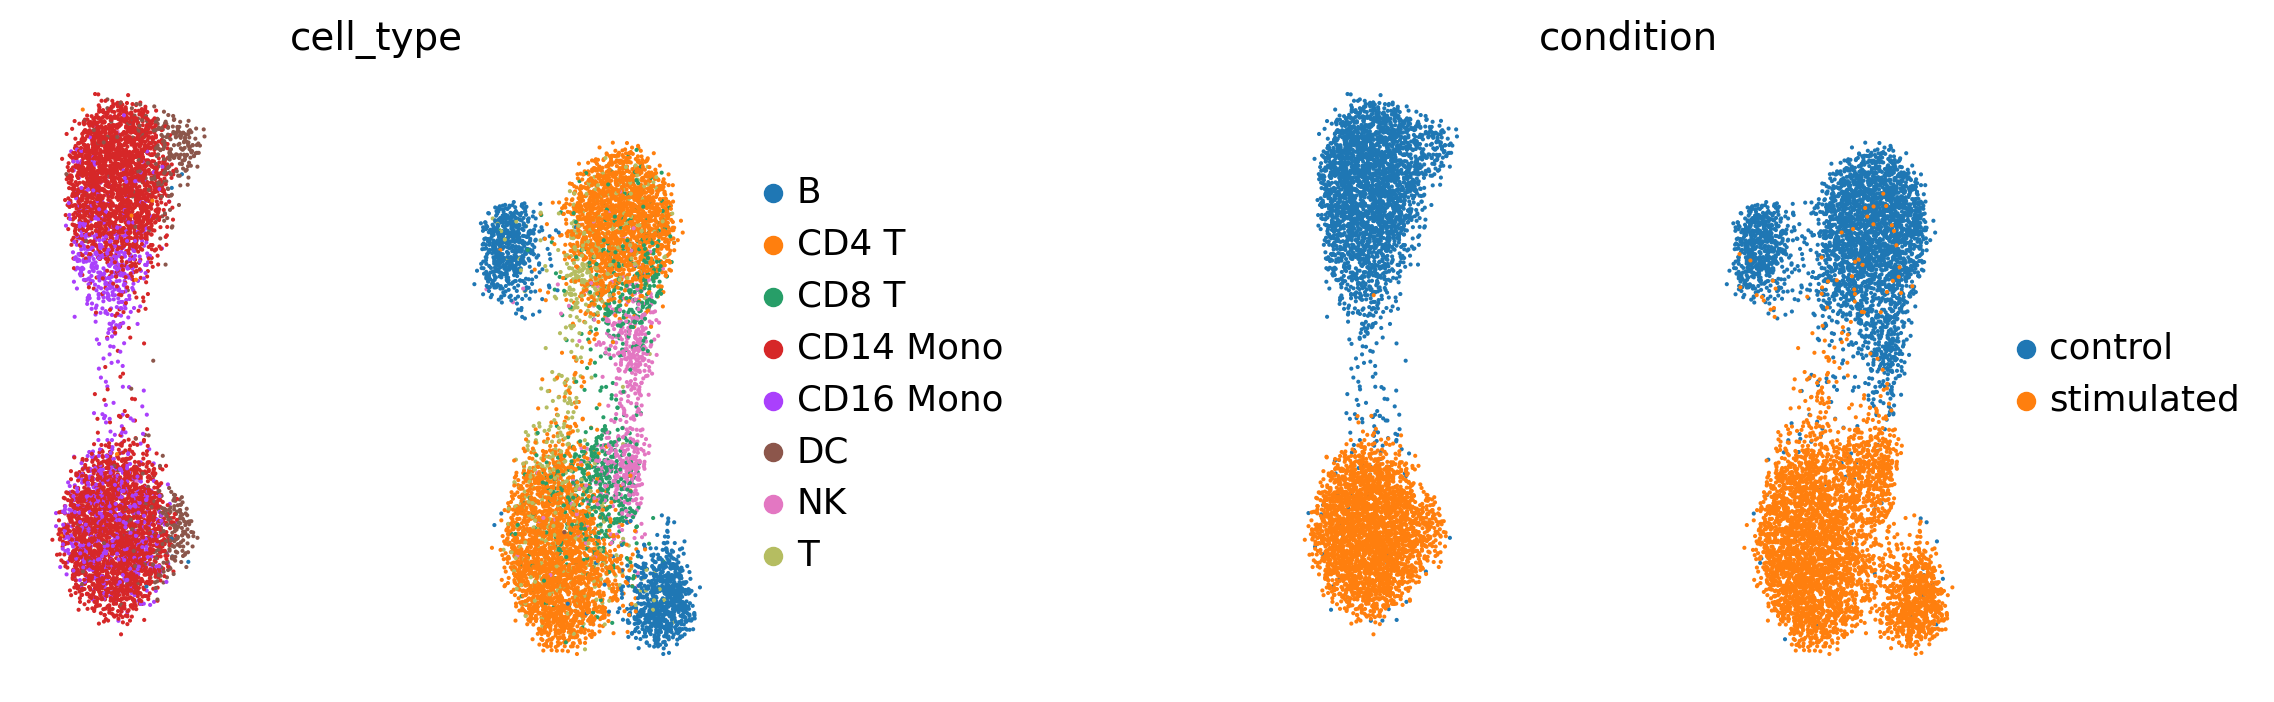

In [187]:
sc.pl.umap(kang, color=['cell_type', 'condition'], frameon=False, wspace=0.6)

In [188]:
kang_pbmc = sc.AnnData.concatenate(adata, kang, batch_key='batch_join')

In [189]:
kang_pbmc.obsm['X_cvae'] = q_intr_cvae.get_latent(kang_pbmc.X, kang_pbmc.obs['study'].tolist(), mean=MEAN)[:, ~inactive_idx]

In [190]:
sc.pp.neighbors(kang_pbmc, use_rep='X_cvae')
sc.tl.umap(kang_pbmc)

In [191]:
kang_pbmc.strings_to_categoricals()

... storing 'batch' as categorical
... storing 'chemistry' as categorical
... storing 'data_type' as categorical
... storing 'final_annotation' as categorical
... storing 'sample_ID' as categorical
... storing 'species' as categorical
... storing 'study' as categorical
... storing 'tissue' as categorical
... storing 'orig.ident' as categorical
... storing 'stim' as categorical
... storing 'seurat_annotations' as categorical
... storing 'condition' as categorical
... storing 'cell_type' as categorical


In [192]:
kang_pbmc.obs['cell_type_joint'] = kang_pbmc.obs['final_annotation'].tolist()

In [193]:
idx_1 = kang_pbmc.obs['cell_type_joint'].astype(str) == 'nan'
idx_2 = kang_pbmc.obs['cell_type'].astype(str) != 'nan'
kang_pbmc.obs['cell_type_joint'][idx_1] = kang_pbmc.obs['cell_type'][idx_2].tolist()

In [194]:
categories = np.unique(kang_pbmc.obs['cell_type_joint'])

In [195]:
categories

array(['B', 'CD10+ B cells', 'CD14 Mono', 'CD14+ Monocytes', 'CD16 Mono',
       'CD16+ Monocytes', 'CD20+ B cells', 'CD4 T', 'CD4+ T cells',
       'CD8 T', 'CD8+ T cells', 'DC', 'Erythrocytes',
       'Erythroid progenitors', 'HSPCs', 'Megakaryocyte progenitors',
       'Monocyte progenitors', 'Monocyte-derived dendritic cells', 'NK',
       'NK cells', 'NKT cells', 'Plasma cells',
       'Plasmacytoid dendritic cells', 'T'], dtype=object)

In [196]:
celltypes_replace = {}
celltypes_replace['CD20+ B cells'] = 'B'
celltypes_replace['CD4 T'] = 'CD4+ T cells'
celltypes_replace['CD8 T'] = 'CD8+ T cells'
celltypes_replace['CD14 Mono'] = 'CD14+ Monocytes'
celltypes_replace['CD16 Mono'] = 'CD16+ Monocytes'
celltypes_replace['NK'] = 'NK cells'

In [197]:
for cat in categories:
    if cat in celltypes_replace:
        kang_pbmc.obs['cell_type_joint'][kang_pbmc.obs['cell_type_joint']==cat] = celltypes_replace[cat]

In [198]:
sc.pp.neighbors(kang_pbmc)

         Falling back to preprocessing with `sc.pp.pca` and default params.


... storing 'cell_type_joint' as categorical


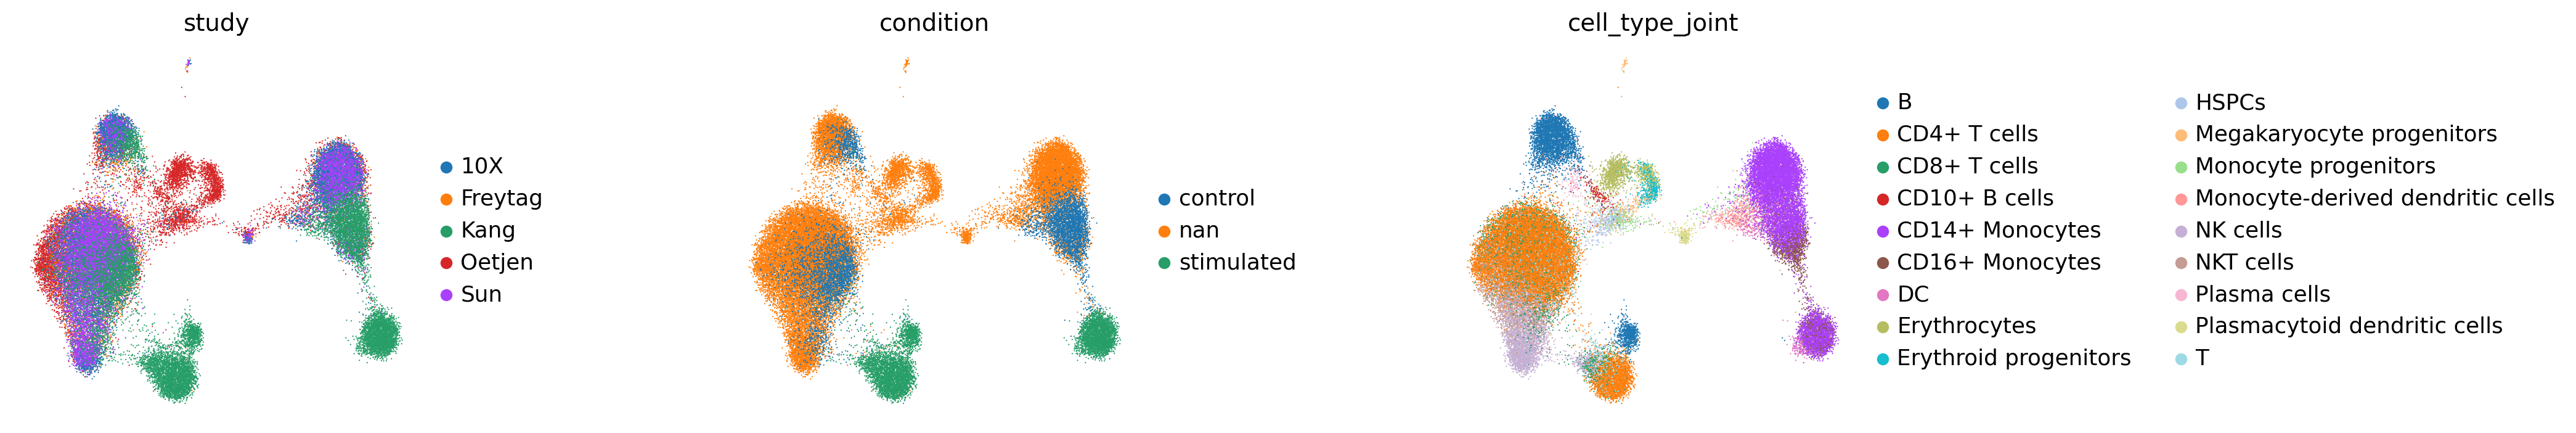

In [199]:
sc.pl.umap(kang_pbmc, color=['study',"condition", 'cell_type_joint'], frameon=False, wspace=0.6)

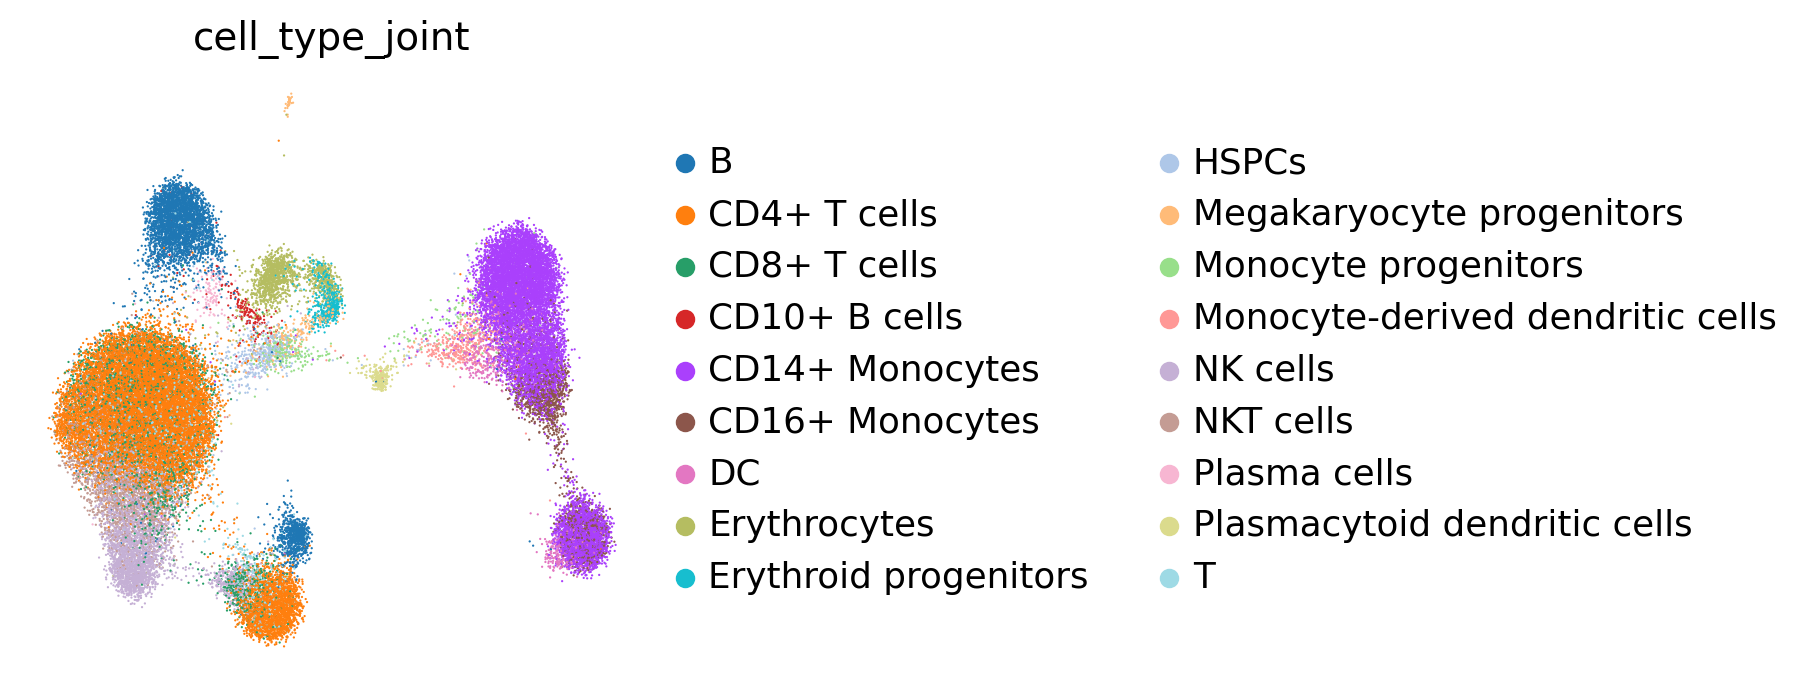

In [200]:
sc.pl.umap(kang_pbmc, color='cell_type_joint', frameon=False, wspace=0.6)

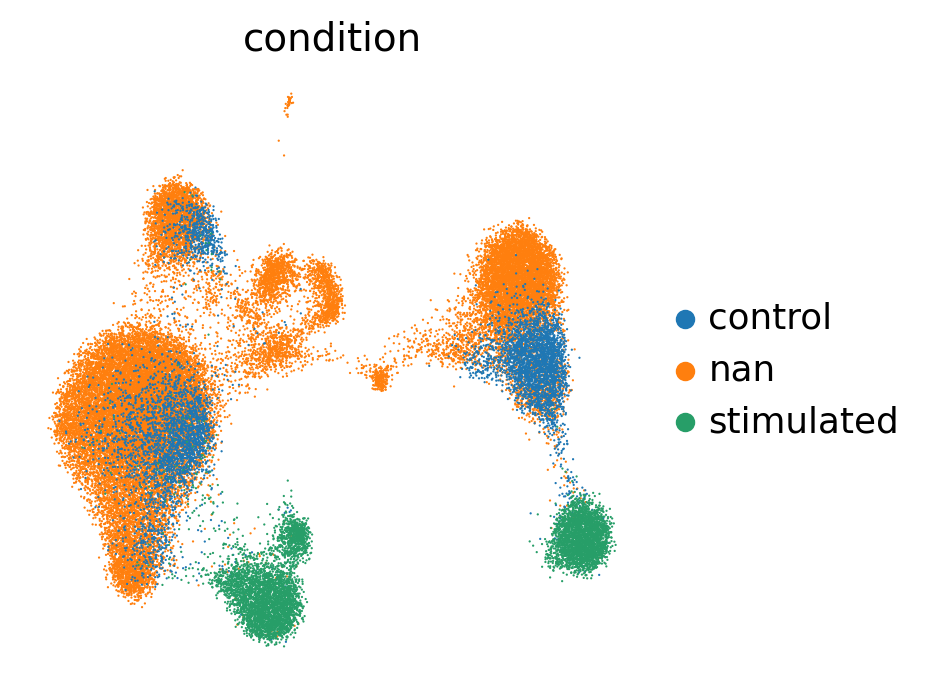

In [201]:
sc.pl.umap(kang_pbmc, color='condition', frameon=False, wspace=0.6)